# Summary

This notebook is inspired by the code provided in the tutorial:

https://blog.fastforwardlabs.com/2018/04/10/pytorch-for-recommenders-101.html

In [8]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import utils
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
device

device(type='cuda')

In [2]:
rating, user_column_index, item_column_index = utils.get_movielens_data()

(100000, 4)
(1682, 24)
(943, 5)


In [3]:
rating["rating"] = rating["rating"]/5

# rating["rating"] =  MinMaxScaler().fit_transform(rating[["rating"]].values).reshape(-1)

In [4]:
n_users = rating["userid"].max() + 1
n_items = rating["itemid"].max() + 1
print(n_users, n_items)
train_df, test_df = utils.movielens_train_test_split(rating)
train_df.shape, test_df.shape

train_df, val_df = utils.movielens_train_test_split(train_df)
train_df.shape, val_df.shape

944 1683


((98105, 49), (943, 49))

<AxesSubplot:>

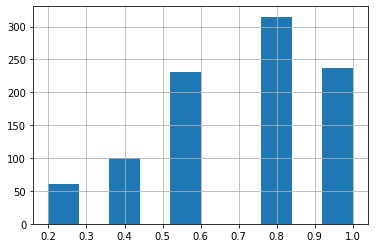

In [5]:
test_df["rating"].hist()

In [6]:
print(np.mean(np.abs(test_df["rating"].values - test_df["rating"].mean())))
print(np.mean(np.abs(test_df["rating"].values - train_df["rating"].mean())))
print(np.mean(np.abs(test_df["rating"].values - train_df["rating"].mode()[0])))
print(np.mean(np.abs(test_df["rating"].values - test_df["rating"].mode()[0])))

0.19339420117424932
0.19594300758655422
0.17985153764581127
0.17985153764581127


# Model definition

In [29]:
class DenseNetWithFeatures(nn.Module):
    def __init__(self, n_users, n_items, n_factors, H1, D_out, n_user_features,
                 n_item_features):
        """
        Simple Feedforward with Embeddings
        """
        super().__init__()
        # user and item embedding layers
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=False)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=False)
        # linear layers
        self.linear1 = torch.nn.Linear(n_factors * 4, H1)
        self.linear2 = torch.nn.Linear(H1, D_out)
        self.user_features = nn.Sequential(
            torch.nn.Linear(n_user_features, n_factors), torch.nn.ReLU(),
            torch.nn.Linear(n_factors, n_factors))
        self.item_features = nn.Sequential(
            torch.nn.Linear(n_item_features, n_factors), torch.nn.ReLU(),
            torch.nn.Linear(n_factors, n_factors),
            torch.nn.Sigmoid()
        )

    def forward(self, users, items, user_features, item_features):
        users_embedding = self.user_factors(users)
        items_embedding = self.item_factors(items)
        user_features_embedding = self.user_features(user_features)
        item_features_embedding = self.item_features(item_features)
        # concatenate user and item embeddings to form input
        x = torch.cat([
            users_embedding, items_embedding, user_features_embedding,
            item_features_embedding
        ], 1)
        h1_relu = F.relu(self.linear1(x))
        output_scores = self.linear2(h1_relu)
        return output_scores

    def predict(self, users, items):
        # return the score
        output_scores = self.forward(users, items)
        return output_scores



DenseNetWithFeatures(
  (user_factors): Embedding(944, 20)
  (item_factors): Embedding(1683, 20)
  (linear1): Linear(in_features=80, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=1, bias=True)
  (user_features): Sequential(
    (0): Linear(in_features=24, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
  )
  (item_features): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Sigmoid()
  )
)

In [50]:
model = DenseNetWithFeatures(n_users,
                             n_items,
                             n_factors=20,
                             H1=20,
                             D_out=1,
                             n_user_features=len(user_column_index),
                             n_item_features=len(item_column_index))
loss_fn = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
# scheduler = None
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
# lmbda = lambda epoch: 0.65 ** epoch
# scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
trainloader = DataLoader(train_df.values, batch_size=128, shuffle=True)
valloader = DataLoader(val_df.values, batch_size=128)
testloader = DataLoader(test_df.values, batch_size=128)
model = model.to(device)
model

DenseNetWithFeatures(
  (user_factors): Embedding(944, 20)
  (item_factors): Embedding(1683, 20)
  (linear1): Linear(in_features=80, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=1, bias=True)
  (user_features): Sequential(
    (0): Linear(in_features=24, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
  )
  (item_features): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Sigmoid()
  )
)

In [51]:
def evaluate(loader):
    maes = []
    for batch in loader:
        user = batch[:, 0].type(torch.LongTensor).to(device)
        item = batch[:, 1].type(torch.LongTensor).to(device)
        user_features = batch[:, user_column_index].type(torch.FloatTensor).to(device)
        item_features = batch[:, item_column_index].type(torch.FloatTensor).to(device)

        score = batch[:, 2].type(torch.FloatTensor)
        prediction = model(user, item, user_features, item_features)
        mae = mean_absolute_error(score.cpu().detach().numpy(),  prediction.cpu().detach().numpy())
        maes.append(mae)
    return np.mean(maes)

In [52]:
losses = []
val_scores = []
test_scores = []
for epoch in range(100):
    losses_epoch = []
    for batch in tqdm(trainloader):
        optimizer.zero_grad()
        user = batch[:, 0].type(torch.LongTensor).to(device)
        item = batch[:, 1].type(torch.LongTensor).to(device)
        user_features = batch[:, user_column_index].type(torch.FloatTensor).to(device)
        item_features = batch[:, item_column_index].type(torch.FloatTensor).to(device)
        score = batch[:, 2].view(-1, 1).type(torch.FloatTensor)
        prediction = model(user, item, user_features, item_features)
        loss = loss_fn(prediction, score.to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        losses_epoch.append(loss.item())
    if scheduler is not None:
        scheduler.step()
    losses.append(np.mean(losses_epoch))
    val_scores.append(evaluate(valloader))
    test_scores.append(evaluate(testloader))
    print(losses[-1])
    print(f"{epoch}) VAL {val_scores[-1]}, TEST {test_scores[-1]}")


0.046597286828124536
0) VAL 0.16576531529426575, TEST 0.17112034559249878



0.036317788244187445
1) VAL 0.1541048288345337, TEST 0.16009050607681274



0.03540798051542611
2) VAL 0.15817147493362427, TEST 0.1635415107011795



0.03495664286489126
3) VAL 0.15586358308792114, TEST 0.16019895672798157



0.03464019858075556
4) VAL 0.15497227013111115, TEST 0.16020037233829498



0.0342212602389294
5) VAL 0.1550682783126831, TEST 0.15493144094944



0.03351539016411077
6) VAL 0.15493236482143402, TEST 0.15569081902503967



0.032844503753790645
7) VAL 0.1544128656387329, TEST 0.15617191791534424



0.032374214696682106
8) VAL 0.15514817833900452, TEST 0.15667594969272614



0.03179611261773762
9) VAL 0.15325698256492615, TEST 0.15841174125671387



0.031359697173615475
10) VAL 0.15891456604003906, TEST 0.16165758669376373



0.03106098976156236
11) VAL 0.1536131203174591, TEST 0.1573559045791626



0.030759960148274666
12) VAL 0.15545117855072021, TEST 0.16015639901161194



0.0304513949842582
13) VAL 0.15393000841140747, TEST 0.15686407685279846



0.030088700084537852
14) VAL 0.15716485679149628, TEST 0.16083599627017975



0.030026527522362505
15) VAL 0.15408462285995483, TEST 0.15977436304092407



0.029818077009496662
16) VAL 0.1536574810743332, TEST 0.1595422923564911



0.029552524445537173
17) VAL 0.15536731481552124, TEST 0.157789945602417



0.02937135060537592
18) VAL 0.15751244127750397, TEST 0.1612415611743927



0.029368037234073822
19) VAL 0.15327179431915283, TEST 0.15839321911334991



0.029100382753989067
20) VAL 0.15281608700752258, TEST 0.1583540141582489



0.028986428535241037
21) VAL 0.1559574007987976, TEST 0.16157002747058868



0.028869144591797905
22) VAL 0.15579000115394592, TEST 0.16020217537879944



0.028733629981029143
23) VAL 0.1553088128566742, TEST 0.16141262650489807



0.02863440382618559
24) VAL 0.15869420766830444, TEST 0.16178302466869354



0.028603692224547946
25) VAL 0.16139128804206848, TEST 0.1658468246459961



0.02858146791245589
26) VAL 0.1550849974155426, TEST 0.16191086173057556



0.028397270144392025
27) VAL 0.1554183065891266, TEST 0.1590099334716797



0.02831146174694522
28) VAL 0.15591496229171753, TEST 0.1593046337366104



0.028397214639023664
29) VAL 0.15513037145137787, TEST 0.16015008091926575



0.028231589167319344
30) VAL 0.15778803825378418, TEST 0.16159400343894958



0.028260402269709998
31) VAL 0.1536964625120163, TEST 0.15829846262931824



0.028142486056592194
32) VAL 0.15762104094028473, TEST 0.15754099190235138



0.02801239002627142
33) VAL 0.15665806829929352, TEST 0.1583305299282074



0.0280284594083897
34) VAL 0.15911203622817993, TEST 0.16145384311676025



0.02809464891418096
35) VAL 0.15477055311203003, TEST 0.15819911658763885



0.02799690344080698
36) VAL 0.15507517755031586, TEST 0.15816044807434082



0.02792571643136704
37) VAL 0.16350963711738586, TEST 0.16280311346054077



0.027846949046290682
38) VAL 0.1546480357646942, TEST 0.15874513983726501



0.02788031779987327
39) VAL 0.15671125054359436, TEST 0.1599801778793335



0.027778567501005012
40) VAL 0.15836189687252045, TEST 0.15922662615776062



0.027804647320990767
41) VAL 0.1563584804534912, TEST 0.1592087596654892



0.02761821289008879
42) VAL 0.1575639545917511, TEST 0.15750649571418762



0.027637796289490285
43) VAL 0.15806561708450317, TEST 0.15996676683425903



0.027609559169434972
44) VAL 0.15935389697551727, TEST 0.15976497530937195


KeyboardInterrupt: 

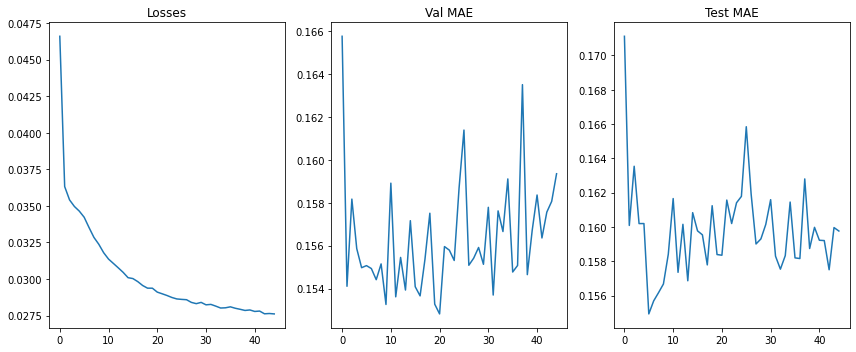

In [53]:
plt.figure(figsize = (12, 5))
plt.subplot(131)
plt.title("Losses")
plt.plot(losses)
plt.subplot(132)
plt.title("Val MAE")
plt.plot(val_scores)

plt.subplot(133)
plt.title("Test MAE")
plt.plot(test_scores)
plt.tight_layout()

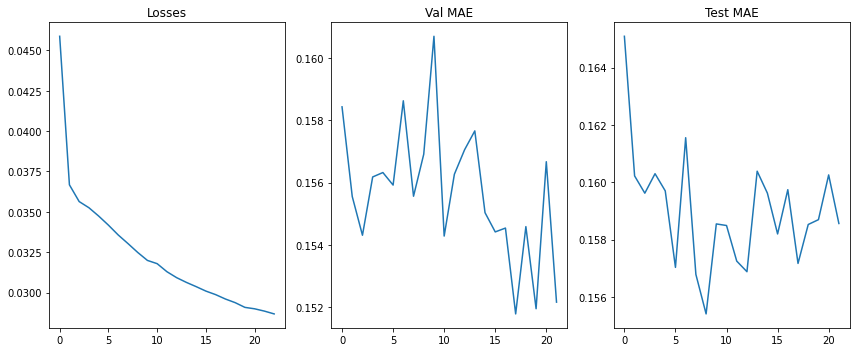

In [24]:
plt.figure(figsize = (12, 5))
plt.subplot(131)
plt.title("Losses")
plt.plot(losses)
plt.subplot(132)
plt.title("Val MAE")
plt.plot(val_scores)

plt.subplot(133)
plt.title("Test MAE")
plt.plot(test_scores)
plt.tight_layout()